(CVXPY) Jul 14 07:44:07 PM: Your problem has 14520 variables, 26175 constraints, and 0 parameters.
(CVXPY) Jul 14 07:44:07 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 14 07:44:07 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 14 07:44:07 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 14 07:44:07 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 14 07:44:07 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 14 07:44:07 PM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffing -> GUROBI
(CVXPY) Jul 14 07:44:07 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 14 07:44:07 PM: Applying reduction Qp2SymbolicQp


                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 14 07:44:08 PM: Applying reduction QpMatrixStuffing
(CVXPY) Jul 14 07:44:10 PM: Applying reduction GUROBI
(CVXPY) Jul 14 07:44:10 PM: Finished problem compilation (took 2.293e+00 seconds).
(CVXPY) Jul 14 07:44:10 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i9-13980HX, instruction set [SSE2|AVX|AVX2]
Thread count: 24 physical cores, 32 logical processors, using up to 32 threads

Non-default parameters:
QCPDual  1

Optimize a model with 35573 rows, 19238 columns and 82441 nonzeros
Model fingerprint: 0xf876d866
Model has 38 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e-01, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+01]
Presolve removed 33564 rows and 17417 columns
Presolve time: 0.02s
Presolved: 20

(CVXPY) Jul 14 07:44:10 PM: Problem status: optimal


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Jul 14 07:44:10 PM: Optimal value: -3.751e+01
(CVXPY) Jul 14 07:44:10 PM: Compilation took 2.293e+00 seconds
(CVXPY) Jul 14 07:44:10 PM: Solver (including time spent in interface) took 3.782e-01 seconds


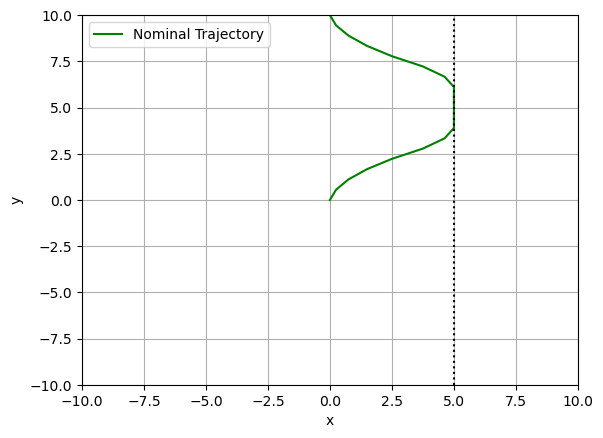

In [39]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
from scipy.linalg import block_diag

# Parameters
T = 20
Ts = 0.5
state_dim = 4
input_dim = 2
output_dim = 2
disturbance_level_dyn = 0
disturbance_level_output = 0.1
response_matrix_bnd = 1e2

# Dynamics matrices
A_t = Ts * np.array([[0, 0, 1, 0],
                     [0, 0, 0, 1],
                     [0, 0, 0, 0],
                     [0, 0, 0, 0]]) + np.eye(state_dim)

B_t = Ts * np.array([[0, 0],
                     [0, 0],
                     [1, 0],
                     [0, 1]])

C_t = np.array([[1, 0, 0, 0],
                [0, 1, 0, 0]])

# Block-diagonal matrices A, B, C
matrices_A = [A_t if i < T - 1 else np.zeros_like(A_t) for i in range(T)]
matrices_B = [B_t if i < T - 1 else np.zeros_like(B_t) for i in range(T)]
matrices_C = [C_t if i < T - 1 else np.zeros_like(C_t) for i in range(T)]

A = block_diag(*matrices_A)
B = block_diag(*matrices_B)
C = block_diag(*matrices_C)

Id = np.eye(T * state_dim)

# Create Z operator (block downshift)
Z = np.zeros((T * state_dim, T * state_dim))
for i in range(1, T):
    Z[i * state_dim:(i + 1) * state_dim, (i - 1) * state_dim:i * state_dim] = np.eye(state_dim)

# Define decision variables
phi_xw = cp.Variable((T * state_dim, T * state_dim))
phi_uw = cp.Variable((T * input_dim, T * state_dim))
phi_xe = cp.Variable((T * state_dim, T * output_dim))
phi_ue = cp.Variable((T * input_dim, T * output_dim))

z = cp.Variable((T * state_dim, 1))
v = cp.Variable((T * input_dim, 1))

# Constraints
constraints = []

# Enforce block lower triangular structure
for i in range(T):
    for j in range(i + 1, T):
        constraints += [phi_xw[i*state_dim:(i+1)*state_dim, j*state_dim:(j+1)*state_dim] == 0]
        constraints += [phi_uw[i*input_dim:(i+1)*input_dim, j*state_dim:(j+1)*state_dim] == 0]
        constraints += [phi_xe[i*state_dim:(i+1)*state_dim, j*output_dim:(j+1)*output_dim] == 0]
        constraints += [phi_ue[i*input_dim:(i+1)*input_dim, j*output_dim:(j+1)*output_dim] == 0]

# Tube affine constraints
A_poly = np.array([
    [1, 0, 0, 0],
    [-1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, -1, 0, 0]
])
state_poly_constraint = np.array([5, 5, 2, 2])
input_poly_constraint = np.array([1, 1])
DimAffine = 1  # Only check the first constraint

robust_tube_size_list = []

# Dynamics & robust constraints
for k in range(T - 1):
    z_k = z[k*state_dim:(k+1)*state_dim]
    z_kp1 = z[(k+1)*state_dim:(k+2)*state_dim]
    v_k = v[k*input_dim:(k+1)*input_dim]
    constraints += [z_kp1 == A_t @ z_k + B_t @ v_k]

    robust_tube_size_state = 0
    for j in range(k + 1):
        phi_kxwj = phi_xw[k*state_dim:(k+1)*state_dim, j*state_dim:(j+1)*state_dim]
        phi_kxej = phi_xe[k*state_dim:(k+1)*state_dim, j*output_dim:(j+1)*output_dim]
        robust_tube_size_state += disturbance_level_dyn * cp.abs(C_t @ phi_kxwj).sum(axis = 1)
        robust_tube_size_state += disturbance_level_output * cp.abs(C_t @ phi_kxej).sum(axis = 1)

    robust_tube_size_input = 0
    for j in range(k + 1):
        phi_kuwj = phi_uw[k*input_dim:(k+1)*input_dim, j*state_dim:(j+1)*state_dim]
        phi_kuej = phi_ue[k*input_dim:(k+1)*input_dim, j*output_dim:(j+1)*output_dim]
        robust_tube_size_input += disturbance_level_dyn * cp.abs(phi_kuwj).sum(axis = 1)
        robust_tube_size_input += disturbance_level_output * cp.abs(phi_kuej).sum(axis = 1)





    constraints += [z_k[0] + robust_tube_size_state[0] <= state_poly_constraint[0]]
    constraints += [v_k[0] + robust_tube_size_input[0] <= input_poly_constraint[0]]
    robust_tube_size_list.append(robust_tube_size_state)

# Initial and terminal constraints
constraints += [z[0:state_dim] == np.zeros((state_dim,))]
constraints += [z[(T-1)*state_dim:T*state_dim] == np.array([[0], [10], [0], [0]])]

# Terminal robust constraint
robust_term_final = 0
for j in range(T):
    phi_xwj = phi_xw[(T-1)*state_dim:T*state_dim, j*state_dim:(j+1)*state_dim]
    phi_xej = phi_xe[(T-1)*state_dim:T*state_dim, j*output_dim:(j+1)*output_dim]
    robust_term_final += disturbance_level_dyn * cp.norm1(A_poly[0] @ phi_xwj)
    robust_term_final += disturbance_level_output * cp.norm1(A_poly[0] @ phi_xej)

z_terminal = z[(T-1)*state_dim:T*state_dim]
constraints += [A_poly[0] @ z_terminal + robust_term_final <= state_poly_constraint[0]]

# SLS constraints
# Phi = cp.hstack([cp.vstack([phi_xw, phi_uw]), cp.vstack([phi_xe, phi_ue])])
# SLS_left = cp.hstack([np.eye(T*state_dim) - Z @ A, -Z @ B])
# constraints += [SLS_left @ Phi == np.hstack([np.eye(T*state_dim), np.zeros((T*state_dim, T*output_dim))])]
# constraints += [Phi @ np.vstack([np.eye(T*state_dim) - Z @ A, -C]) == np.vstack([np.eye(T*state_dim), np.zeros((T*input_dim, T*state_dim))])]

constraints += [(Id - Z@A) @ phi_xw - Z @ B @ phi_uw == Id]
constraints += [(Id - Z@A) @ phi_xe - Z @ B @ phi_ue == np.zeros((T*input_dim, T*state_dim)).T]
constraints += [phi_xw @ (Id - Z@A) - phi_xe @ C == Id]
constraints += [phi_uw @ (Id - Z@A) - phi_ue @ C == np.zeros((T*input_dim, T*state_dim))]

# Objective
objective = 0
for k in range(T - 1):
    z_k = z[k*state_dim:(k+1)*state_dim]
    z_kp1 = z[(k+1)*state_dim:(k+2)*state_dim]
    objective += cp.sum_squares(z_kp1[0:2] - z_k[0:2]) -z_k[0]
# objective += 1e1 * (cp.norm_inf(phi_xw) + cp.norm_inf(phi_xe) + cp.norm_inf(phi_uw) + cp.norm_inf(phi_ue))

# Problem
prob = cp.Problem(cp.Minimize(objective), constraints)
prob.solve(solver=cp.GUROBI, verbose=True)

# Extract solution
z_val = z.value.reshape((T, state_dim)).T
v_val = v.value.reshape((T, input_dim)).T

# Plot
plt.figure()
plt.plot(z_val[0, :], z_val[1, :], 'g', label='Nominal Trajectory')
plt.axvline(x=state_poly_constraint[0], color='k', linestyle=':')
plt.xlim([-10, 10])
plt.ylim([-10, 10])
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid()
plt.show()


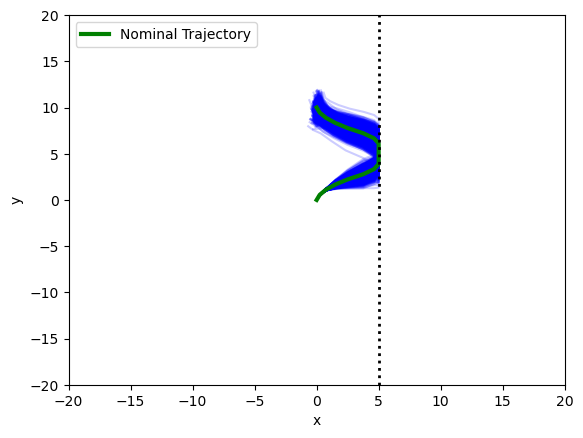

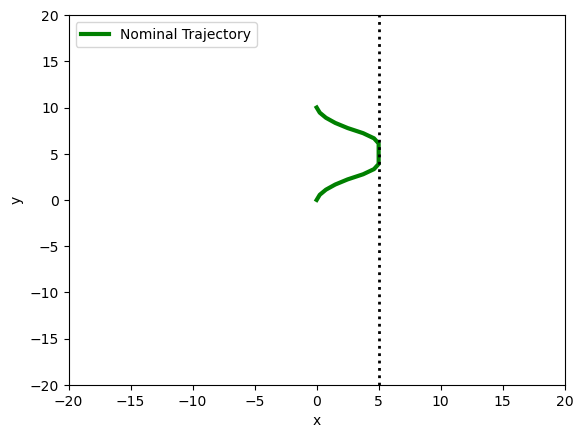

In [41]:
# Roll outs of the nominal trajectory with and without feedback

num_rollout = 1000
error_signal_feedback = [None] * num_rollout
error_signal_openloop = [None] * num_rollout
output_trajectory_closedloop = [None] * num_rollout
input_trajectory_closedloop = [None] * num_rollout

unstacked_z = z_val
unstacked_v = v_val

plt.figure()

for rollout_cnt in range(num_rollout):
    # Open-loop rollout (no feedback)
    x_init = np.zeros(state_dim)
    x = np.zeros((state_dim, T))
    for i in range(T - 1):
        noise = disturbance_level_dyn * (np.random.rand(state_dim) * 2 - 1)
        x[:, i + 1] = A_t @ x[:, i] + B_t @ unstacked_v[:, i] + noise
    error_signal_openloop[rollout_cnt] = np.vstack((x[0, :] - unstacked_z[0, :], x[1, :] - unstacked_z[1, :]))

    # Feedback rollout (with feedback)
    val_phi_ue = phi_ue.value.copy()
    val_phi_ue[np.isnan(val_phi_ue)] = 0
    val_phi_uw = phi_uw.value.copy()
    val_phi_uw[np.isnan(val_phi_uw)] = 0
    val_phi_xe = phi_xe.value
    val_phi_xw = phi_xw.value

    # Feedback gain
    K = val_phi_ue - val_phi_uw @ np.linalg.inv(val_phi_xw) @ val_phi_xe

    x_init_fb = disturbance_level_dyn * (np.random.rand(state_dim) * 2 - 1)
    x_fb = np.zeros((state_dim, T))
    x_fb[:, 0] = x_init_fb
    feedback_u = np.zeros((input_dim, T))

    for i in range(T):
        feedback_control = np.zeros(input_dim)
        for j in range(i + 1):
            observation_noise = disturbance_level_output * (np.random.rand(output_dim) * 2 - 1)
            idx_K_row = slice(i * input_dim, (i + 1) * input_dim)
            idx_K_col = slice(j * output_dim, (j + 1) * output_dim)
            feedback_control += K[idx_K_row, idx_K_col] @ (C_t @ x_fb[:, j] - C_t @ unstacked_z[:, j] + observation_noise)
        dynamics_noise = disturbance_level_dyn * (np.random.rand(state_dim) * 2 - 1)
        if i < T - 1:
            x_fb[:, i + 1] = A_t @ x_fb[:, i] + B_t @ (feedback_control + unstacked_v[:, i]) + dynamics_noise
        feedback_u[:, i] = feedback_control

    plt.plot(x_fb[0, :], x_fb[1, :], "b", alpha=0.2)
    error_signal_feedback[rollout_cnt] = np.vstack((x_fb[0, :] - unstacked_z[0, :], x_fb[1, :] - unstacked_z[1, :]))
    output_trajectory_closedloop[rollout_cnt] = x_fb
    input_trajectory_closedloop[rollout_cnt] = feedback_u

plt.plot(unstacked_z[0, :], unstacked_z[1, :], "g", label="Nominal Trajectory", linewidth=3)
plt.axvline(x=state_poly_constraint[0], linestyle=":", color="k", linewidth=2)
plt.xlim([-20, 20])
plt.ylim([-20, 20])
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

plt.figure()
plt.plot(unstacked_z[0, :], unstacked_z[1, :], "g", label="Nominal Trajectory", linewidth=3)
plt.axvline(x=state_poly_constraint[0], linestyle=":", color="k", linewidth=2)
plt.xlim([-20, 20])
plt.ylim([-20, 20])
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [10]:
# constraints += [(Id - Z@A) @ phi_xw - Z @ B @ phi_uw == Id]
# constraints += [(Id - Z@A) @ phi_xe - Z @ B @ phi_ue == np.zeros((T*input_dim, T*state_dim))]
# constraints += [phi_xw @ (Id - Z@A) - phi_xe @ C == Id]
# constraints += [phi_uw @ (Id - Z@A) - phi_ue @ C == np.zeros((T*input_dim, T*state_dim))]

# Display the sizes of the matrices
print("Size of phi_xw:", phi_xw.shape)
print("Size of phi_uw:", phi_uw.shape)  
print("Size of phi_xe:", phi_xe.shape)
print("Size of phi_ue:", phi_ue.shape)
# Display the sizes of the matrices Id, Z, A ,B and their products in the constraints
print("Size of Id:", Id.shape)
print("Size of Z:", Z.shape)
print("Size of A:", A.shape)
print("Size of B:", B.shape)
print("Size of (Id - Z@A):", (Id - Z@A).shape)
# Display the sizes of the products in the constraints
print("Size of (Id - Z@A) @ phi_xw:", ((Id - Z@A) @ phi_xw).shape)
print("Size of Z @ B @ phi_uw:", (Z @ B @ phi_uw).shape)
print("Size of (Id - Z@A) @ phi_xe:", ((Id - Z@A) @ phi_xe).shape)
print("Size of Z @ B @ phi_ue:", (Z @ B @ phi_ue).shape)

Size of phi_xw: (80, 80)
Size of phi_uw: (40, 80)
Size of phi_xe: (80, 40)
Size of phi_ue: (40, 40)
Size of Id: (80, 80)
Size of Z: (80, 80)
Size of A: (80, 80)
Size of B: (80, 40)
Size of (Id - Z@A): (80, 80)
Size of (Id - Z@A) @ phi_xw: (80, 80)
Size of Z @ B @ phi_uw: (80, 80)
Size of (Id - Z@A) @ phi_xe: (80, 40)
Size of Z @ B @ phi_ue: (80, 40)


In [14]:
for i in range(T-1):
    print(robust_tube_size_list[i].value)

[0. 0.]
[0. 0.]
[3.00002959 0.        ]
[1.50005918 3.        ]
[0.10067281 4.31819806]
[1.31035505e-06 4.31819806e+00]
[1.64663916e-12 4.31819806e+00]
[5.97241758e-12 1.22513682e+01]
[6.96675031e-12 1.35969149e+01]
[7.88506699e-12 1.10210534e+01]
[7.04251606e-12 1.02146890e+01]
[5.37755455e-12 9.40832454e+00]
[1.07532532e-11 8.60196013e+00]
[3.11472070e-11 6.18472208e+00]
[4.58916917e-11 6.46842791e+00]
[4.53032818e-06 6.47281292e+00]
[ 0.01247033 10.04343115]
[0.04980693 9.81300337]
[0.21729303 9.89828261]


In [18]:
max(phi_ue.value.reshape(-1,order="F"))

np.float64(20.000000009666085)